# Feature extraction from images

The generative AI part of this notebook requires an AWS account with bedrock model senabled.

In [3]:
%pip install -r requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import ipywidgets as widgets
from IPython.display import display, Markdown, JSON, clear_output
import textwrap
import helpers as aws
import os, json
from tabulate import tabulate
import cv2 
import matplotlib.pyplot as plt 
from contextlib import contextmanager
import textwrap
import numpy as np

local_images = [f for f in os.listdir('.') if f.endswith('.jpg')]

@contextmanager
def image_spinner(out):
    image = open('spinner.gif', 'rb').read()
    with out:
        clear_output()
        display(widgets.Image(value=image, width=100))
        yield
        clear_output()


def print_wrapped(text, width=80):
    for line in textwrap.wrap(text, width):
        print(line)

# Traditional Feature Engineering

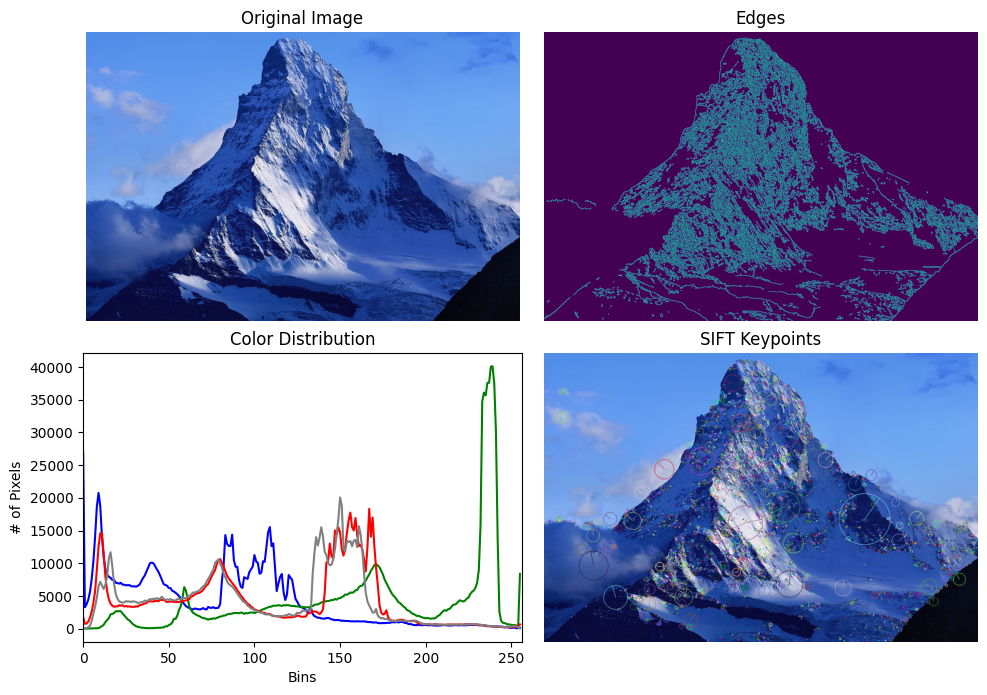

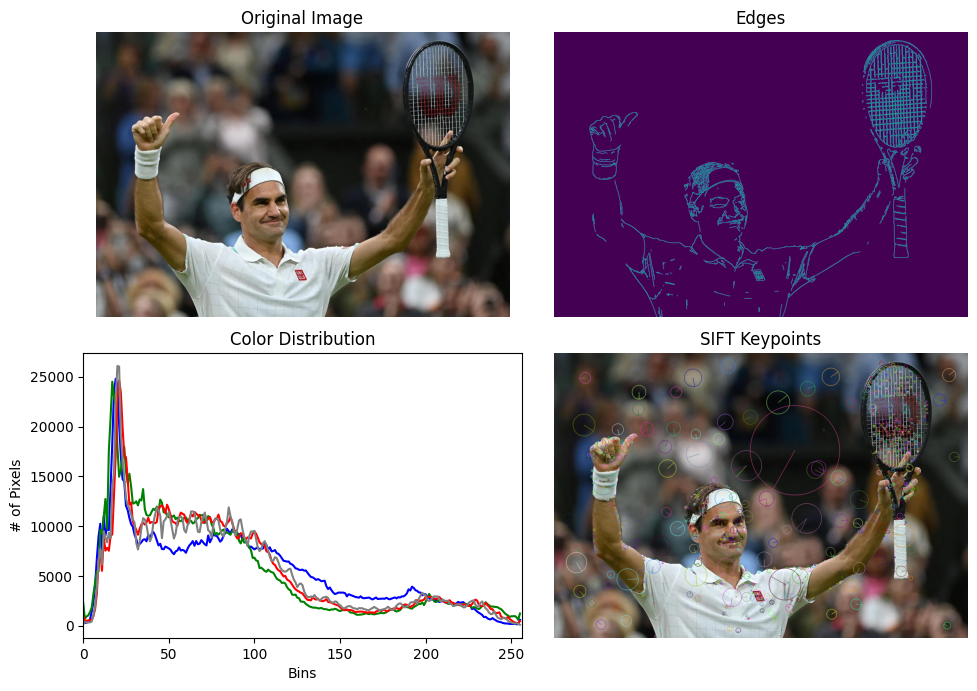

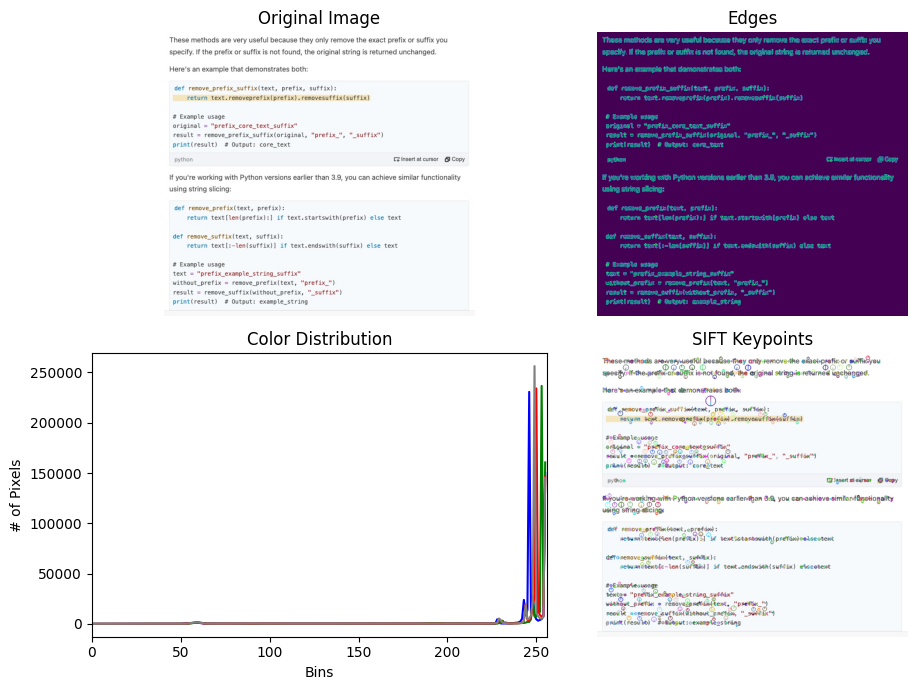

12


In [5]:
def plot_image_edges(file):
    # Load the image
    image = cv2.imread(file) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Display the original image and the edges
    plt.figure(figsize=(10,7))
    plt.subplot(2, 2, 1)
    plt.title('Original Image')
    plt.axis("off")
    plt.imshow(image)

    # display canny edges
    edges = cv2.Canny(gray, 100, 200)
    plt.subplot(2, 2, 2)
    plt.title('Edges')
    plt.axis("off")
    plt.imshow(edges)

    # display harris corners
    # dst = cv2.cornerHarris(gray, 3, 5, 0.1)
    # corners = dst > 0.05 * dst.max()
    # coord = np.argwhere(corners)
    # img = image.copy()
    # for y, x in coord:
    #     cv2.circle(img, (x, y), 3, (0, 0, 255), -1)

    # plt.subplot(2, 2, 3)
    # plt.title('Harris Corners')
    # plt.axis("off")
    # plt.imshow(img)

    # display color histogram
    blue_color = cv2.calcHist([image], [0], None, [256], [0, 256]) 
    red_color = cv2.calcHist([image], [1], None, [256], [0, 256]) 
    green_color = cv2.calcHist([image], [2], None, [256], [0, 256]) 
    gray_scale = cv2.calcHist([gray], [0], None, [256], [0, 256])

    # Separate Histograms for each color 
    plt.subplot(2, 2, 3)
    plt.title("Color Distribution") 
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    plt.plot(blue_color, color="blue")
    plt.plot(green_color, color="green")
    plt.plot(red_color, color="red")
    plt.plot(gray_scale, color="gray")
    plt.xlim([0, 256])

    # display sift features
    sift = cv2.SIFT_create()
    keypoints = sift.detect(gray, None)
    img = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.subplot(2, 2, 4)
    plt.title('SIFT Keypoints')
    plt.axis("off")
    plt.imshow(img)

    plt.tight_layout()
    plt.show()

for file in local_images:
    plot_image_edges(file)

print(12)

# GenAI based feature engineering

In [6]:
prompts = aws.image_prompts.list()

out_image = widgets.Output(layout = {'padding': '0px 50px', 'max_width': '400px'})
out_text = widgets.Output(layout = {'padding': '0px 50px', 'max_width': '1000px'})

opt_image = widgets.Dropdown(description='images', options=local_images, value=None)
opt_prompt = widgets.Dropdown(description='prompt', options=prompts, value=None)

image = None

def on_image_change(*args):
    global image
    opt_prompt.value = None
    out_text.clear_output()
    image = open(opt_image.value, 'rb').read()
    with out_image:
        clear_output()
        display(widgets.Image(value=image,width=300))

def on_prompt_change(*args):
    text = ""
    if image == None: return
    with image_spinner(out_text):
        text = aws.create_image_description(image, opt_prompt.value)

    with out_text:
        clear_output()
        display(Markdown(text))


# observe changes
opt_image.observe(on_image_change, 'value')
opt_prompt.observe(on_prompt_change, 'value')

# display
form_data = widgets.GridBox([opt_image, opt_prompt], layout = {'margin': '0px 0px 20px', 'grid_template_columns': 'min-content min-content'})
display(widgets.VBox([form_data, widgets.HBox([out_image, out_text])]))

# Feature extraction from audio (speech)

To enable the demo, download podcast from [here](https://podcast.datenschutzpartner.ch/273-outsourcing-cloud-behoerden-kanton-zuerich-david-rosenthal) and store it in an S3 bucket. Then update the s3 location for the transcribe job

In [13]:
import time
mp3_s3_location = 's3://drweb-playground/media/podcast-swissgerman.mp3'
aws.s3_download_location(mp3_s3_location)

job = aws.TranscribeJob('podcast-swissgerman-2', mp3_s3_location, 'de-CH')
job.start()

max_count = 300
progress = widgets.IntProgress(
    value=0,
    min=0,
    max=max_count,
    step=1,
    description='Transcribing:',
    bar_style='success',
    orientation='horizontal',
    layout=widgets.Layout(width='50%')
)
display(progress)

count = 0
while count <= max_count:
    progress.value = count
    if job.is_finished(): 
        break
    time.sleep(1)
    count += 1

text = job.get_transcript()
Markdown(text[:4000]+"...")


IntProgress(value=0, bar_style='success', description='Transcribing:', layout=Layout(width='50%'), max=300)

Guten Tag. Mein Name ist Martin Steiger. In der heutigen Datenschutzplauderreihe freue ich mich sehr, einen Spezialgast und Wiederholungsgast begrüssen zu dürfen. Der David Rosenthal. David, einmal mehr. Herzlich willkommen Ja, Sally, Sally, Martin. Das ist wie immer super in deinem Podcast. Lässig bist dabei, David. Das heutige Thema einmal mehr ist Cloud Thematik Outsourcing. Also nicht Kai Thematik, wo du in letzter Zeit natürlich auch viel machst, bei der Gelegenheit wieder mal den Hinweis darauf, dass ihr bei Fischer ja eine super Kai Serien haben. Unterdessen glaube es, bei 20 Folgen tun ich sicherheit der Show noch zu verlinken. Aber eben wir haben immer noch ganz klassische Outsourcinghema. Heute habe ich dich eingeladen, dass wir über das Outsourcing beim Staat reden, weil es gibt. zwei Entwicklungen gerade im Kanton Zürich. Es gibt einen Vorentwurf über das Gesetz über die digitalen Basisdienste. Dort hat es einen umstrittenen Paragraph 17 und die Datenschutzbeauftragung vom Kanton Zürich, die hat den Leitfaden für die Gemeinde veröffentlicht. Microsoft 365 hat die schon zu verlinkt. Wenn man dort rein schaut, dann stolpere ich zumindest so über das eine oder andere auch mit Blick auf meine Eigentätigkeit. Du machst natürlich auch sehr viel, vielleicht noch viel mehr in diesem Bereich. Darum legen wir doch los. Wunderbar. Genau Ich habe jetzt mal als erstes einfach den Leitfahrt aufgerufen, aber auch den Gesetzesentwurf und werde das mal vielleicht durchstrehlen und mal schauen, was da so steht. Die Leitfaden von den Datenschutzbeauftriter ist auch als Anleitung gedacht. Es gibt auch eine Checklisten, weil die Datenschutzbeauftriter muss amigs auch Vorabkontrollen machen, damit Gemeinden das einsetzen, muss 160 Gemeinden im Kanton Zürich. Das Erste, was ich noch interessant finde, ist das Thema Rechtsgrundlagenanalyse, wo da gefordert wird. Und eine Klassifizierung von den Daten, dass man so die Daten muss einteilen. Und das entspricht jetzt auch aus meiner Sicht nicht ganz dem, was man jetzt als Unternehmen als Private würde machen. Darf ich. Wie sieht das aus mit der Klassifizierung? Ja. Also, das ist ein bisschen ein Problem. Das, glaube ich, historische Gründe hat. Das wird ja. Es gibt ja die klassische Unterscheidung im Datenschutz zwischen den normalen Personendaten und den besonders schützenswerten oder im im Kanton Zürich den besonderen Personendaten. Das ist klar, dass es das braucht, weil es da zum Teil unterschiedliche rechtliche Grundlagen braucht, um die Sachen zu beurteilen spielt beim Outsourcing aber eigentlich nicht in so einer Rolle. Und nach meiner Erfahrung wird auch immer alles so gemacht, dass der Sicherheitsstandard eigentlich auch für die besonderen Daten gilt. Aber dann gibt es noch eine Spezialitäten, die ich in der Diskussion um die ganzen Cloud Geschichten erlebt habe. ich nie auflösen, ist, dass man jetzt anfängt, nur zu differenzieren zwischen einem normalen Amtsgeheimnis und einem besonderen Amtsgeheimnis. Weil das gibt es eigentlich nicht im Schweizer Recht. Das ist aus meiner Sicht einfach das. Das ist nicht da. Und es gibt auch nicht ein besonderes Berufsgeheimnis und ein nicht besonderes Berufsgeheimnis. Es gibt höchstens verschiedene Rechtsgrundlagen für das Amtsgeheimnis, aber das Amtsgeheimnis, die Straffolge sind 23 DGB und beim Berufsgeheimnis d 21 oder dann so Namen wie Krankengesetz. Und die muss man natürlich zum Teil auslegen, was sie bedeuten. Und das ist auch der Hintergrund von dem. Aber es gibt nicht jetzt ein Amtsgeheimnis, das schärfer ist als andere einfach von der Natur her. Und das Ganze kommt eigentlich aus einer Diskussion, dass natürlich die Datenschutzbeauftragte und auch gewisse andere Datenschutzbeauftragte in anderen Kantonen irgendwo gemerkt haben, dass sie nicht alles in einen Topf werfen können. Und dann haben sie quasi wie die Figur von dem besonderen Amtsgeheimnis erfunden. Es ist aber so, dass wenn man schauen, was eigentlich die verschiedenen Gesetze ...

In [8]:
summary = aws.get_text_summary(text, 'summarize')
Markdown(summary)

This conversation discusses cloud computing and data protection issues in Swiss public administration, particularly in the canton of Zurich. Key points include:

1. The Zurich Data Protection Officer has issued guidelines for municipalities using Microsoft 365, which are seen as overly restrictive and impractical.

2. There's debate over the classification of data and the concept of "special official secrets," which the speakers argue is not legally defined.

3. The proposed law on digital basic services in Zurich is criticized for effectively ruling out cloud use due to unrealistic encryption requirements.

4. The speakers argue that many concerns about cloud services are misplaced, and that on-premises solutions often have more security issues than cloud providers.

5. They discuss the challenges of risk assessment and the importance of having informed discussions about real risks rather than focusing on theoretical issues.

6. The conversation touches on recent security incidents at Microsoft and the need to consider vendor lock-in and dependency risks.

7. The speakers emphasize the importance of practical solutions and risk management rather than attempting to achieve perfect security.

In [9]:
key_words = aws.get_text_summary(text, 'keywords')
Markdown(key_words)

Here are the key points extracted from the conversation:

Keywords:
- Cloud computing
- Data protection
- Microsoft 365
- Outsourcing
- Government/public sector
- Risk assessment
- Encryption
- Compliance
- Data sovereignty
- EU Data Boundary
- Cloud Act
- Transparency
- Security incidents
- Vendor lock-in

Categories:
- Technology
- Law
- Government
- Privacy
- Cybersecurity

The conversation covers complex issues around cloud adoption by government entities in Switzerland, particularly focused on data protection concerns, compliance requirements, and risk assessments related to using services like Microsoft 365. It discusses the challenges of balancing security, functionality and data sovereignty when outsourcing IT infrastructure to cloud providers.

In [10]:
json_metadata = aws.get_text_summary(text, 'json')
print(json_metadata)

Here is a summary of the key metadata extracted from the text:

{
  "title": "Diskussion über Cloud-Nutzung und Datenschutz bei Behörden",
  "author": null,
  "date": null,
  "summary": "Martin Steiger und David Rosenthal diskutieren über Cloud-Nutzung und Datenschutz bei Behörden, insbesondere im Kanton Zürich. Sie besprechen Herausforderungen bei der Nutzung von Cloud-Diensten wie Microsoft 365, rechtliche Rahmenbedingungen, Risikobewertungen und Empfehlungen von Datenschutzbeauftragten. Kritisiert werden übertriebene Einschränkungen und mangelnde sachliche Diskussion. Die Experten plädieren für einen pragmatischeren Umgang mit Cloud-Diensten unter Berücksichtigung von Sicherheitsaspekten.",
  "keywords": [
    "Cloud",
    "Datenschutz", 
    "Behörden",
    "Microsoft 365",
    "Outsourcing",
    "Risikobewertung",
    "Datenschutzbeauftragte",
    "Verschlüsselung",
    "Compliance"
  ],
  "source": "Podcast-Transkript"
}
